In [1]:
import gc
import os
import random
import time
import warnings
warnings.simplefilter("ignore")
import os
#import pdb
#import zipfile
#import pydicom
from albumentations import *
from albumentations.pytorch import ToTensor
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
import tifffile as tiff
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm_notebook as tqdm
import segmentation_models_pytorch
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark=True

In [2]:
def set_seed(seed=2**3):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
#set_seed(121)

In [3]:
fold = 0
nfolds = 5
reduce = 4
sz = 256

BATCH_SIZE = 2
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 16
SEED = 2020
TH = 0.39  #threshold for positive predictions

DATA = '/home/mlrig/Documents/kaggle/Hubmap/test/'
LABELS = '/home/mlrig/Documents/kaggle/Hubmap/train.csv'
MASKS = '/home/mlrig/Documents/TFG/carla-simulator/out_seg_city/'
TRAIN = '/home/mlrig/Documents/TFG/carla-simulator/rgb/'


In [4]:
df = pd.DataFrame(os.listdir(TRAIN),columns=["id"])
images = []
for file in os.listdir("/home/mlrig/Documents/kaggle/Hubmap/train"):
    if file.endswith(".tiff"):
            images.append(file.split(".")[0])

In [5]:
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self,df,classes,classes_dict,tfms):
        self.df = df
        self.tfms = tfms
        self.classes = classes
        self.classes_dict = classes_dict
        
    def __len__(self):
        return len(self.df)
    def modify_label(self,label,classes):
        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if not (label[i,j] in classes):
                        label[i,j] = len(self.classes)-1
                else:      
                    label[i,j] = self.classes_dict[label[i,j]]

        return label            
    
    def __getitem__(self, idx):
        fname = self.df[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.COLOR_BGR2RGB)
        #mask = np.sum(mask,axis=2)
        #mask = self.modify_label(mask,classes)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            #mask = np.sum(img,axis=2)
            
            img,mask = augmented['image'],augmented['mask']
           # print(torch.nn.functional.one_hot(img2tensor(mask).long().squeeze(0)))
        return img2tensor(img),torch.nn.functional.one_hot(img2tensor(mask).long().squeeze(0),num_classes=len(self.classes)).permute(-1,0,1).float(),fname

In [6]:
def get_UnetPlusPlus():
    model =  smp.Unet(
                 encoder_name='se_resnet50',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=len(classes))
    return model
def get_aug(p=1.0):
    return Compose([
        Resize(512,512),
    ])

In [7]:
classes = [142,162,-1]
classes_dict = {}
classes_dict[142] = 0
classes_dict[162] = 1
ds_t = HuBMAPDataset(df["id"],classes,classes_dict,get_aug())
ds_v = HuBMAPDataset(df["id"],classes,classes_dict,get_aug())
dataloader_t = torch.utils.data.DataLoader(ds_t,batch_size=1, shuffle=True,num_workers=NUM_WORKERS)
dataloader_v = torch.utils.data.DataLoader(ds_t,batch_size=1, shuffle=True,num_workers=NUM_WORKERS)
sigmoid = torch.nn.Sigmoid()
model = get_UnetPlusPlus().to(DEVICE)
model.load_state_dict(torch.load("FPN-0-model_0.85.pth"))

<All keys matched successfully>

In [8]:
dataiter = iter(dataloader_t)
image,labels,fname = dataiter.next()
image = image.to(DEVICE)
output = model(image)
output = sigmoid(output)

In [9]:
print(fname)

('75559.png',)


In [10]:
output = output > 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


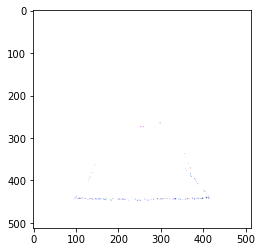

In [11]:
plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy()*255)

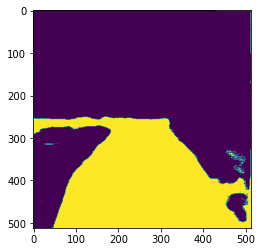

In [12]:
plt.imshow(output.cpu().squeeze().permute(1, 2, 0).numpy()[:,:,0])

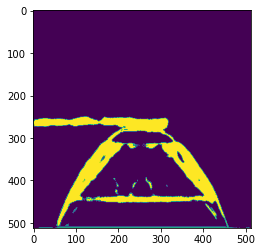

In [13]:
plt.imshow(output.cpu().squeeze().permute(1, 2, 0).numpy()[:,:,1])

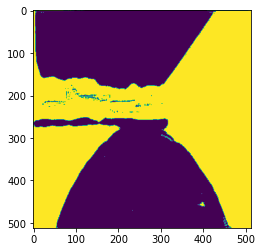

In [14]:
plt.imshow(output.cpu().squeeze().permute(1, 2, 0).numpy()[:,:,2])



In [15]:
output.cpu().squeeze().permute(1, 2, 0).numpy()[:,:,0].shape

(512, 512)